# r/AnarchyChess Analysis
- focus on board 2

In [120]:
from PIL import Image
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio  # for GIF creation
import os
from datetime import datetime

final_canvas = Image.open("2022_canvas_final.png") # load in final r/place 2022 canva

In [19]:
parquet_file = "2022pyarrow.parquet"

lf = pl.scan_parquet(parquet_file)  # LazyFrame (efficient for big data)
lf.collect().head()

timestamp,pixel_color,x,y,user_id_int
datetime[μs],str,i64,i64,u32
2022-04-04 00:53:51.577,"""#00CCC0""",826,1048,0
2022-04-04 00:53:53.758,"""#94B3FF""",583,1031,1
2022-04-04 00:53:54.685,"""#6A5CFF""",1873,558,2
2022-04-04 00:54:57.541,"""#009EAA""",1627,255,3
2022-04-04 00:55:16.307,"""#94B3FF""",49,1478,4


## anarchy chess

## board 1

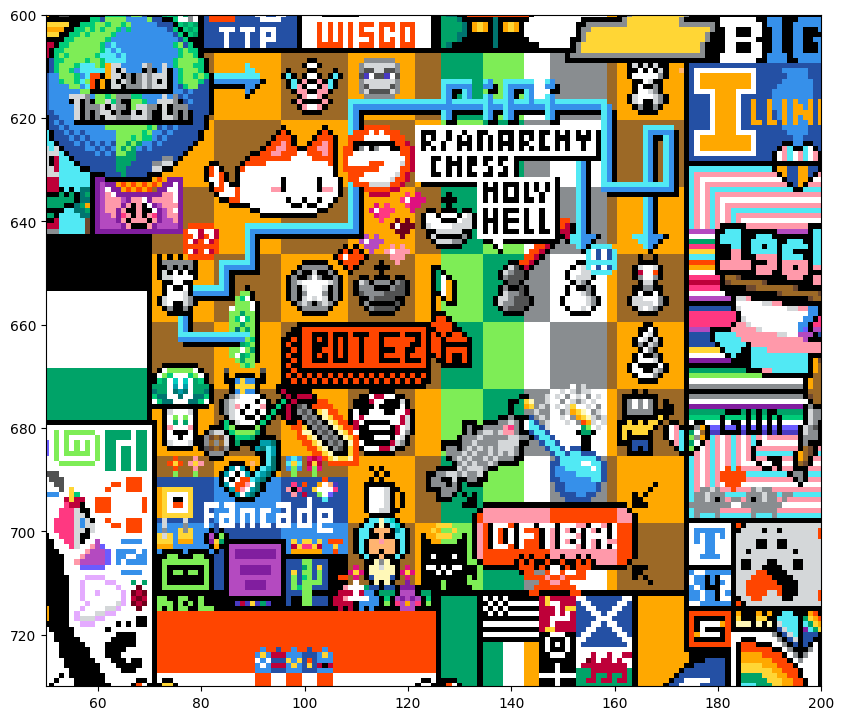

In [ ]:
board1 = [(124, 661)] # center of board1

width, height = 200, 730 # zoom into these dim

# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(final_canvas)

# mark top pixels
for (x, y) in board1:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(50, 200)  # adjust 
ax.set_ylim(730, 600)
plt.show()

## board 2

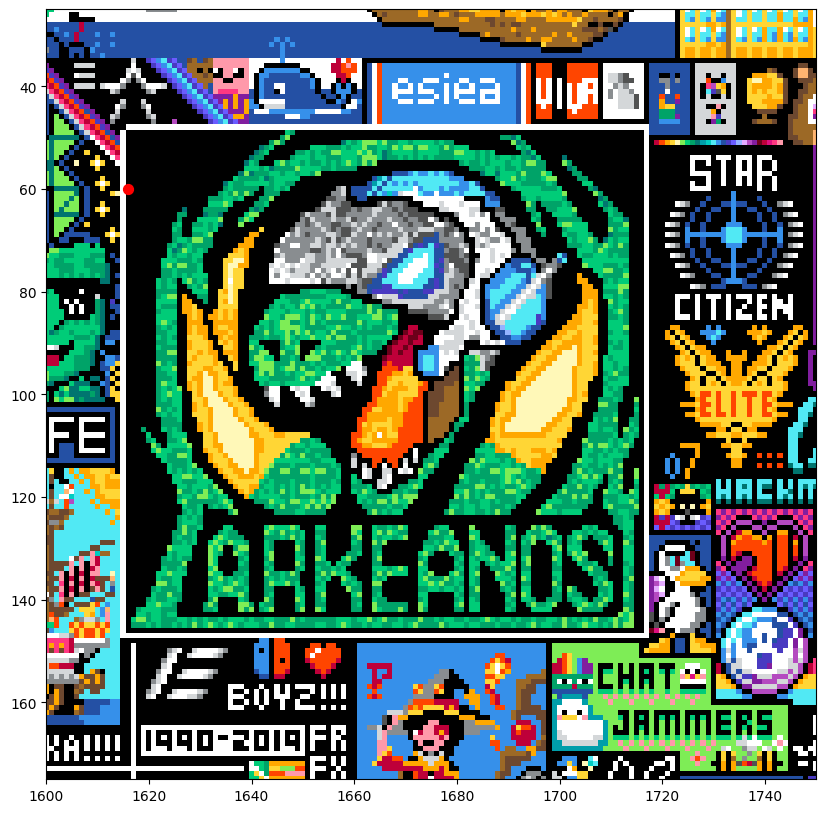

In [13]:
board2 = [(1616, 60)] # center of board

width, height = 2000, 100 # zoom into these dim

# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(final_canvas)

# mark top pixels
for (x, y) in board2:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(1600, 1750)  # adjust 
ax.set_ylim(175, 25)
plt.show()

### Timelapse of Board 2

In [82]:
# define board2 coordinate range
x_min, x_max = 1610, 1730
y_min, y_max = 40, 160

# get values for timelapse
df_board2 = (
    lf.filter(
        (pl.col("x") >= x_min) & (pl.col("x") <= x_max) &
        (pl.col("y") >= y_min) & (pl.col("y") <= y_max) & # filter thru dims
        (pl.col("timestamp") >= pl.lit("2022-04-02 16:30:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) # start time when board doubled
    )
    .with_columns(
        pl.col("timestamp").dt.truncate("30m").alias("time_bin")  # group into 30min bins
    )
    .group_by("time_bin", "x", "y")
    .agg(pl.col("pixel_color").last())  # Get the last pixel color per hour / get most common color
    .collect()
)

print(df_board2.shape)  # check final size
df_board2.head()  # Preview results

(150480, 4)


time_bin,x,y,pixel_color
datetime[μs],i64,i64,str
2022-04-03 17:30:00,1637,42,"""#FF4500"""
2022-04-04 23:30:00,1660,112,"""#FFFFFF"""
2022-04-03 10:30:00,1705,80,"""#9C6926"""
2022-04-04 11:00:00,1695,146,"""#B44AC0"""
2022-04-04 07:00:00,1688,44,"""#000000"""


In [85]:
output_dir = "board2_frames" # directory to store images
os.makedirs(output_dir, exist_ok=True)

df_board2 = df_board2.sort("time_bin") # sort data by time_bin to process changes in chrono order
time_bins = df_board2["time_bin"].unique().sort() # unique timebins in order

# dictionary to store  last known color of each (x, y) pixel
pixel_state = {}  # Key = (x, y), Value = pixel_color

frames = []  # list to store images for GIF

# process each timestamp
for i, time_bin in enumerate(time_bins):
    df_snapshot = df_board2.filter(df_board2["time_bin"] == time_bin)

    # update pixel states with new colors
    for row in df_snapshot.iter_rows(named=True):
        x, y, color = row["x"], row["y"], row["pixel_color"]
        pixel_state[(x, y)] = color  # update last known color for this pixel

    fig, ax = plt.subplots(figsize=(8, 8)) # full frame 

    # convert stored pixel colors into lists for plotting
    if pixel_state:  # ensure there are pixels to plot
        x_coords, y_coords, colors = zip(*[(x, y, color) for (x, y), color in pixel_state.items()])
        ax.scatter(x_coords, y_coords, c=colors, s=5, marker='s')  # scatter plot with stored pixel colors

    ax.invert_yaxis()
    ax.set_title(f"r/AnarchyChess Board 2 at {time_bin}")

    frame_path = os.path.join(output_dir, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=300, bbox_inches='tight') # save frame

    plt.draw()
    buf = fig.canvas.tostring_rgb()
    img = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,)) # convert plot to img for GIF
    frames.append(img)

    plt.close()

imageio.mimsave("board2_timelapse.gif", frames, duration=0.25)  # gif, 0.25s per frame

/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_52838/187756655.py:37: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  buf = fig.canvas.tostring_rgb()


- focus on timeframes 2022-04-04 19:00:00 to 2022-04-04 19:30:00 (when takeover happens)

In [130]:
# define board2 coordinate range
x_min, x_max = 1610, 1730
y_min, y_max = 40, 160

# get values for timelapse
new = (
    lf.filter(
        (pl.col("x") >= x_min) & (pl.col("x") <= x_max) &
        (pl.col("y") >= y_min) & (pl.col("y") <= y_max) & # filter thru dims
        (pl.col("timestamp") >= pl.lit("2022-04-02 16:30:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) # start time when board doubled
    )
    .with_columns(
        pl.col("timestamp").dt.truncate("1m").alias("time_bin")  # group into 1min bins
    )
    .group_by("time_bin", "x", "y")
    .agg(pl.col("pixel_color").last())  # Get the last pixel color per hour / get most common color
    .collect()
)

print(df_board2.shape)  # check final size
df_board2.head()  # Preview results

(150480, 5)


time_bin,x,y,pixel_color,is_arkeanos
datetime[μs],i64,i64,str,bool
2022-04-02 16:30:00,1654,67,"""#000000""",true
2022-04-02 16:30:00,1687,85,"""#000000""",true
2022-04-02 16:30:00,1686,49,"""#000000""",true
2022-04-02 16:30:00,1620,61,"""#9C6926""",true
2022-04-02 16:30:00,1620,49,"""#6A5CFF""",true


In [111]:
# Directory to store images
output_dir = "new_takeover_frames"
os.makedirs(output_dir, exist_ok=True)

# Sort data by time_bin to process changes in chronological order
new = new.sort("time_bin")  # Assuming 'new' is your DataFrame
time_bins = new["time_bin"].unique().sort()  # Get unique time_bins sorted in order

# Dictionary to store the last known color of each (x, y) pixel
pixel_state = {}  # Key = (x, y), Value = pixel_color

# List to store frames for GIF
frames = []

# Define the start time for screenshots
start_takeover = "2022-04-04 19:00:00"
start_time = datetime.strptime(start_takeover, "%Y-%m-%d %H:%M:%S")

# Process each timestamp
for i, time_bin in enumerate(time_bins):
    # time_bin is already a datetime object, no need to convert it
    current_time = time_bin  # Just use time_bin as datetime

    # Skip frames before the start time
    if current_time < start_time:
        # Update the pixel states but don't save the frame yet
        df_snapshot = new.filter(new["time_bin"] == time_bin)
        for row in df_snapshot.iter_rows(named=True):
            x, y, color = row["x"], row["y"], row["pixel_color"]
            pixel_state[(x, y)] = color  # Update last known color for this pixel
        continue  # Skip to the next iteration without saving the frame

    # Once we reach the start time, begin saving frames
    df_snapshot = new.filter(new["time_bin"] == time_bin)

    # Update pixel states with new colors
    for row in df_snapshot.iter_rows(named=True):
        x, y, color = row["x"], row["y"], row["pixel_color"]
        pixel_state[(x, y)] = color  # Update last known color for this pixel

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))  # Full frame

    # Convert stored pixel colors into lists for plotting
    if pixel_state:  # Ensure there are pixels to plot
        x_coords, y_coords, colors = zip(*[(x, y, color) for (x, y), color in pixel_state.items()])
        ax.scatter(x_coords, y_coords, c=colors, s=5, marker='s')  # Scatter plot with stored pixel colors

    ax.invert_yaxis()
    ax.set_title(f"r/AnarchyChess Board 2 Takeover at {time_bin}")

    # Save the frame
    frame_path = os.path.join(output_dir, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=300, bbox_inches='tight')  # Save frame

    plt.draw()
    buf = fig.canvas.tostring_rgb()
    img = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Convert plot to image for GIF
    frames.append(img)

    plt.close()

# Create the GIF
imageio.mimsave("new_takeover_timelapse.gif", frames, duration=0.25)  # GIF, 0.25s per frame


/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_52838/1047457630.py:64: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  buf = fig.canvas.tostring_rgb()


In [ ]:
# Directory to store images
output_dir = "new_takeover_frames"
os.makedirs(output_dir, exist_ok=True)

# Sort data by time_bin to process changes in chronological order
new = new.sort("time_bin")  # Assuming 'new' is your DataFrame
time_bins = new["time_bin"].unique().sort()  # Get unique time_bins sorted in order

# Dictionary to store the last known color of each (x, y) pixel
pixel_state = {}  # Key = (x, y), Value = pixel_color

# List to store frames for GIF
frames = []

# Define the start and end time for screenshots
start_takeover = "2022-04-04 19:00:00"
start_time = datetime.strptime(start_takeover, "%Y-%m-%d %H:%M:%S")

end_takeover = "2022-04-04 19:30:00"
end_time = datetime.strptime(end_takeover, "%Y-%m-%d %H:%M:%S")

# Process each timestamp
for i, time_bin in enumerate(time_bins):
    # time_bin is already a datetime object, no need to convert it
    current_time = time_bin  # Just use time_bin as datetime

    # Skip frames before the start time
    if current_time < start_time:
        # Update the pixel states but don't save the frame yet
        df_snapshot = new.filter(new["time_bin"] == time_bin)
        for row in df_snapshot.iter_rows(named=True):
            x, y, color = row["x"], row["y"], row["pixel_color"]
            pixel_state[(x, y)] = color  # Update last known color for this pixel
        continue  # Skip to the next iteration without saving the frame

    # Stop processing after the end time
    if current_time > end_time:
        break  # Exit the loop when the end time is reached

    # Once we reach the start time, begin saving frames
    df_snapshot = new.filter(new["time_bin"] == time_bin)

    # Update pixel states with new colors
    for row in df_snapshot.iter_rows(named=True):
        x, y, color = row["x"], row["y"], row["pixel_color"]
        pixel_state[(x, y)] = color  # Update last known color for this pixel

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))  # Full frame

    # Convert stored pixel colors into lists for plotting
    if pixel_state:  # Ensure there are pixels to plot
        x_coords, y_coords, colors = zip(*[(x, y, color) for (x, y), color in pixel_state.items()])
        ax.scatter(x_coords, y_coords, c=colors, s=5, marker='s')  # Scatter plot with stored pixel colors

    ax.invert_yaxis()
    ax.set_title(f"r/AnarchyChess Board 2 Takeover at {time_bin}")

    # Save the frame
    frame_path = os.path.join(output_dir, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=300, bbox_inches='tight')  # Save frame

    plt.draw()
    buf = fig.canvas.tostring_rgb()
    img = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Convert plot to image for GIF
    frames.append(img)

    plt.close()

# Create the GIF
imageio.mimsave("new_takeover_timelapse.gif", frames, duration=0.25)  # GIF, 0.25s per frame


# stop screenshots after endtime

### Data Visualizations 

data visualization ideas:
1. pixel takeover rate (what colors used by arkeanos)
2. spacial spread (heatmap)
3. competition over takeover
4. bot detection
5. player involvement (could see if other users were helping)
6. how coordinated was takeover (look at time it took) :/

1. pixel takeover rate

In [174]:
x_min, x_max = 1650, 1717 # define coordinates where rectangle is
y_min, y_max = 48, 147

start_timeframe = "2022-04-04 20:00:00" # time range for takeover
end_timeframe = "2022-04-04 20:30:00"

arkeanos_data = (
    lf.filter(
        (pl.col("x") >= x_min) & (pl.col("x") <= x_max) &
        (pl.col("y") >= y_min) & (pl.col("y") <= y_max) & # filter through dimensions
        (pl.col("timestamp") >= pl.lit(start_timeframe).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) & 
        (pl.col("timestamp") <= pl.lit(end_timeframe).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))
    )
    .with_columns(
        pl.col("timestamp").dt.truncate("1m").alias("time_bin")  # group into 1-minute bins
    )
    .group_by("time_bin", "x", "y")
    .agg(pl.col("pixel_color").last())  # get last pixel color per 1-minute bin
    .collect()
)

print(arkeanos_data.head())

shape: (5, 4)
┌─────────────────────┬──────┬─────┬─────────────┐
│ time_bin            ┆ x    ┆ y   ┆ pixel_color │
│ ---                 ┆ ---  ┆ --- ┆ ---         │
│ datetime[μs]        ┆ i64  ┆ i64 ┆ str         │
╞═════════════════════╪══════╪═════╪═════════════╡
│ 2022-04-04 20:13:00 ┆ 1704 ┆ 140 ┆ #00CC78     │
│ 2022-04-04 20:07:00 ┆ 1679 ┆ 139 ┆ #000000     │
│ 2022-04-04 20:23:00 ┆ 1690 ┆ 80  ┆ #51E9F4     │
│ 2022-04-04 20:02:00 ┆ 1663 ┆ 127 ┆ #00A368     │
│ 2022-04-04 20:01:00 ┆ 1691 ┆ 50  ┆ #000000     │
└─────────────────────┴──────┴─────┴─────────────┘


In [175]:
# Group by pixel color and count occurrences
color_counts = arkeanos_data.group_by("pixel_color").agg(
    pl.count().alias("color_count")
)

# Sort the colors by frequency (in descending order)
sorted_colors = color_counts.sort("color_count", descending=True)

# Check the top colors
top_colors = sorted_colors.head(10)  # Adjust 10 to whatever number of top colors you need

# Extract the top colors into a list (or set) for arkeanos_colors
arkeanos_colors = set(top_colors["pixel_color"])

print(top_colors)

shape: (10, 2)
┌─────────────┬─────────────┐
│ pixel_color ┆ color_count │
│ ---         ┆ ---         │
│ str         ┆ u32         │
╞═════════════╪═════════════╡
│ #000000     ┆ 3526        │
│ #00A368     ┆ 1686        │
│ #00CC78     ┆ 1517        │
│ #FFFFFF     ┆ 894         │
│ #7EED56     ┆ 439         │
│ #51E9F4     ┆ 336         │
│ #FFD635     ┆ 302         │
│ #FFA800     ┆ 257         │
│ #D4D7D9     ┆ 244         │
│ #898D90     ┆ 235         │
└─────────────┴─────────────┘


/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_52838/3864725121.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("color_count")


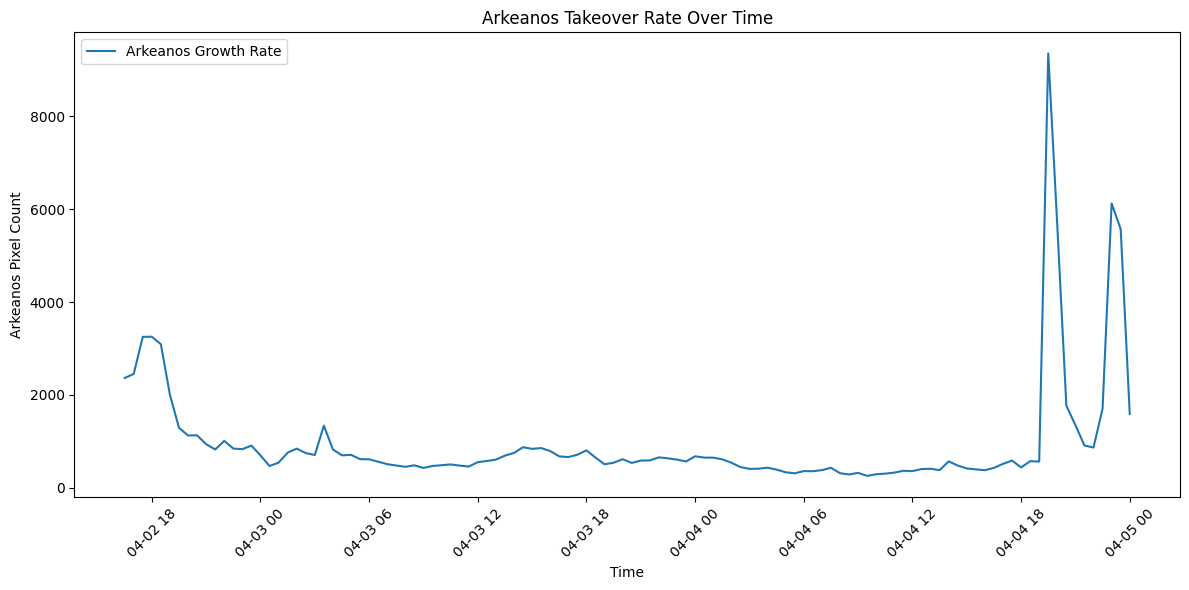

In [177]:
# Filter the DataFrame for Arkeanos colors and create a new column 'is_arkeanos'
df_board2 = df_board2.with_columns(
    pl.col("pixel_color").is_in(arkeanos_colors).alias("is_arkeanos")
)

# Group by time_bin and sum the 'is_arkeanos' to calculate the takeover rate
growth_over_time = df_board2.group_by("time_bin").agg(
    pl.sum("is_arkeanos").alias("arkeanos_growth")
)

# Convert to pandas for easier plotting
growth_over_time_pd = growth_over_time.to_pandas()

# Plot the takeover rate over time
plt.figure(figsize=(12, 6))
plt.plot(growth_over_time_pd["time_bin"], growth_over_time_pd["arkeanos_growth"], label="Arkeanos Growth Rate")
plt.xlabel("Time")
plt.ylabel("Arkeanos Pixel Count")
plt.title("Arkeanos Takeover Rate Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

check if this is right later?

Was the takeover sudden (viral spread) or gradual?
Was there resistance (temporary decline, slow growth)?
What was the peak takeover period

/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_52838/2619220824.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("color_count")


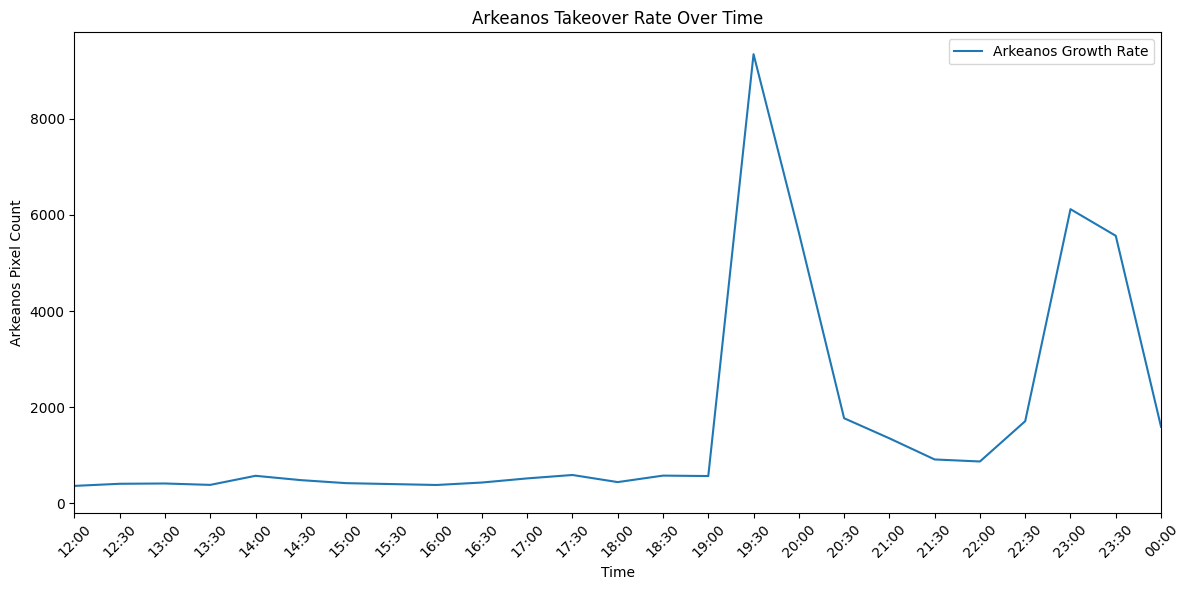

In [184]:
color_counts = arkeanos_data.group_by("pixel_color").agg(
    pl.count().alias("color_count")
)

sorted_colors = color_counts.sort("color_count", descending=True)
top_colors = sorted_colors.head(10)
arkeanos_colors = set(top_colors["pixel_color"])

df_board2 = df_board2.with_columns(
    pl.col("pixel_color").is_in(arkeanos_colors).alias("is_arkeanos")
)

growth_over_time = df_board2.group_by("time_bin").agg(
    pl.sum("is_arkeanos").alias("arkeanos_growth")
)

growth_over_time_pd = growth_over_time.to_pandas()

# Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(growth_over_time_pd["time_bin"], growth_over_time_pd["arkeanos_growth"], label="Arkeanos Growth Rate")
# plt.xlabel("Time")
# plt.ylabel("Arkeanos Pixel Count")
# plt.title("Arkeanos Takeover Rate Over Time")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.legend()
# plt.show()

import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(growth_over_time_pd["time_bin"], growth_over_time_pd["arkeanos_growth"], label="Arkeanos Growth Rate")
plt.xlabel("Time")
plt.ylabel("Arkeanos Pixel Count")
plt.title("Arkeanos Takeover Rate Over Time")

# Zoom into the desired time range
plt.xlim(pd.to_datetime("2022-04-04 12:00:00"), pd.to_datetime("2022-04-05 00:00:00"))

# Set x-axis major locator to every 15 minutes
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))

# Format the x-axis labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Rotate and format the labels
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()



In [181]:
print(arkeanos_colors)

{'#51E9F4', '#D4D7D9', '#FFFFFF', '#000000', '#FFA800', '#7EED56', '#00CC78', '#00A368', '#FFD635', '#898D90'}


4. bot detection?

In [185]:
# Group by x and y, count the number of occurrences of time_bin for each pixel (x, y)
df_repeats = arkeanos_data.group_by(["x", "y"]).agg(
    pl.count("time_bin").alias("time_bin_count")  # Count how many times the pixel has appeared in time_bin
).sort("time_bin_count", descending=True)  # Sort by count in descending order

# Show the top 10 most frequently updated pixels
df_repeats.head(10)

x,y,time_bin_count
i64,i64,u32
1672,76,30
1672,77,30
1671,77,26
1671,76,23
1673,76,21
1651,89,21
1677,133,19
1652,91,18
1652,90,18
